In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T

from imageio import imread

import numpy as np

import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

C:\Users\suhas\AppData\Local\Temp\ipykernel_17360\40568114.py:16: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


In [3]:

vggnet = torchvision.models.vgg19(pretrained=True)

for p in vggnet.parameters():
    p.requires_grad = False
  
vggnet.eval()

C:\Users\suhas\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\suhas\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [4]:
# send the network to the GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

vggnet.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [5]:
# img4content = imread('https://upload.wikimedia.org/wikipedia/commons/6/61/De_nieuwe_vleugel_van_het_Stedelijk_Museum_Amsterdam.jpg')
# img4style   = imread('https://upload.wikimedia.org/wikipedia/commons/c/c5/Edvard_Munch%2C_1893%2C_The_Scream%2C_oil%2C_tempera_and_pastel_on_cardboard%2C_91_x_73_cm%2C_National_Gallery_of_Norway.jpg')
img4content = imread("./target.jpg")
img4style = imread("./starry-night.jpg")
# initialize the target image and random numbers
img4target = np.random.randint(low=0,high=255,size=img4content.shape,dtype=np.uint8)

print(img4content.shape)
print(img4target.shape)
print(img4style.shape)

C:\Users\suhas\AppData\Local\Temp\ipykernel_17360\4026892859.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img4content = imread("./target.jpg")


(721, 1280, 3)
(721, 1280, 3)
(800, 1280, 3)


C:\Users\suhas\AppData\Local\Temp\ipykernel_17360\4026892859.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img4style = imread("./starry-night.jpg")


In [6]:
Ts = T.Compose([ T.ToTensor(),
                 T.Resize(256),
                 T.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
               ])

# apply them to the images ("unsqueeze" to make them a 4D tensor) and push to GPU
img4content = Ts( img4content ).unsqueeze(0).to(device)
img4style   = Ts( img4style   ).unsqueeze(0).to(device)
img4target  = Ts( img4target  ).unsqueeze(0).to(device)

print(img4content.shape)
print(img4target.shape)
print(img4style.shape)

torch.Size([1, 3, 256, 454])
torch.Size([1, 3, 256, 454])
torch.Size([1, 3, 256, 409])


C:\Users\suhas\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


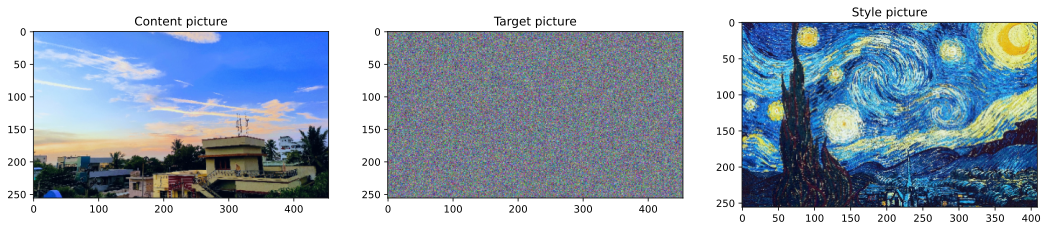

In [7]:


# Let's have a look at the "before" pics
fig,ax = plt.subplots(1,3,figsize=(18,6))

pic = img4content.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[0].imshow(pic)
ax[0].set_title('Content picture')

pic = img4target.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[1].imshow(pic)
ax[1].set_title('Target picture')

pic = img4style.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[2].imshow(pic)
ax[2].set_title('Style picture')

plt.show()

In [8]:


# A function that returns feature maps

def getFeatureMapActs(img,net):
  
  # initialize feature maps as a list
  featuremaps = []
  featurenames = []

  convLayerIdx = 0

  # loop through all layers in the "features" block
  for layernum in range(len(net.features)):
    
    # print out info from this layer
    # print(layernum,net.features[layernum])

    # process the image through this layer
    img = net.features[layernum](img)

    # store the image if it's a conv2d layer
    if 'Conv2d' in str(net.features[layernum]):
      featuremaps.append( img )
      featurenames.append( 'ConvLayer_' + str(convLayerIdx) )
      convLayerIdx += 1
  
  return featuremaps,featurenames

In [10]:
# A function that returns the Gram matrix of the feature activation map

def gram_matrix(M):
  
  # reshape to 2D
  _,chans,height,width = M.shape
  M = M.reshape(chans,height*width)  

  # compute and return covariance matrix
  gram = torch.mm(M,M.t()) / (chans*height*width)
  return gram

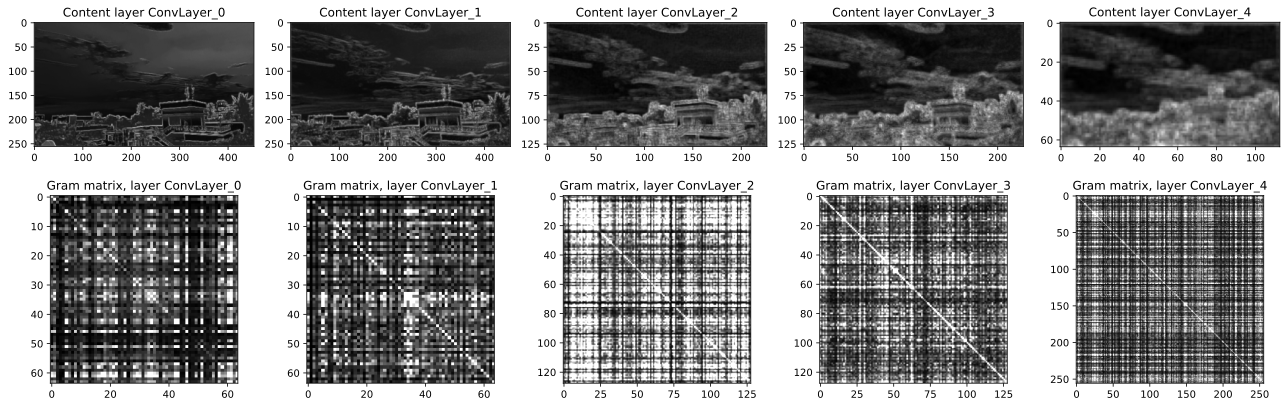

In [11]:
# let's see what the "content" image looks like
contentFeatureMaps,contentFeatureNames = getFeatureMapActs(img4content,vggnet)


fig,axs = plt.subplots(2,5,figsize=(18,6))
for i in range(5):

  # average over all feature maps from this layer, and normalize
  pic = np.mean( contentFeatureMaps[i].cpu().squeeze().numpy() ,axis=0)
  pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))

  axs[0,i].imshow(pic,cmap='gray')
  axs[0,i].set_title('Content layer ' + str(contentFeatureNames[i]))


  ### now show the gram matrix
  pic = gram_matrix(contentFeatureMaps[i]).cpu().numpy()
  pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))

  axs[1,i].imshow(pic,cmap='gray',vmax=.1)
  axs[1,i].set_title('Gram matrix, layer ' + str(contentFeatureNames[i]))

plt.tight_layout()
plt.show()

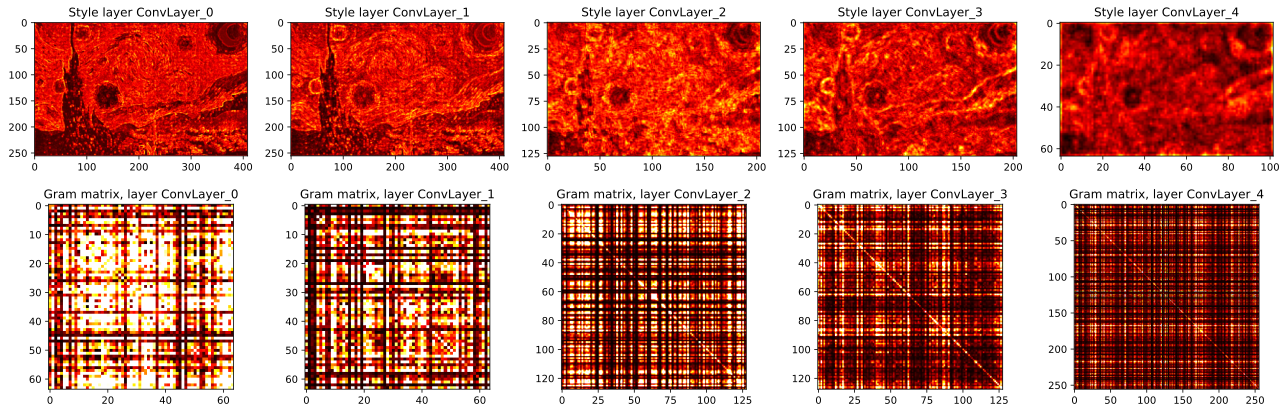

In [12]:
# repeat for the "style" image
styleFeatureMaps,styleFeatureNames = getFeatureMapActs(img4style,vggnet)


fig,axs = plt.subplots(2,5,figsize=(18,6))
for i in range(5):

  # average over all feature maps from this layer, and normalize
  pic = np.mean( styleFeatureMaps[i].cpu().squeeze().numpy() ,axis=0)
  pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))

  axs[0,i].imshow(pic,cmap='hot')
  axs[0,i].set_title('Style layer ' + str(styleFeatureNames[i]))


  ### now show the gram matrix
  pic = gram_matrix(styleFeatureMaps[i]).cpu().numpy()
  pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))

  axs[1,i].imshow(pic,cmap='hot',vmax=.1)
  axs[1,i].set_title('Gram matrix, layer ' + str(styleFeatureNames[i]))

plt.tight_layout()
plt.show()
     

In [14]:
# which layers to use
layers4content = [ 'ConvLayer_1', 'ConvLayer_4', 'ConvLayer_2' ]
layers4style   = [ 'ConvLayer_1','ConvLayer_2','ConvLayer_3','ConvLayer_4','ConvLayer_5' ]
weights4style  = [      0.2      ,     .1      ,     .1      ,     .04      ,     .01 ]     

In [15]:
# make a copy of the target image and push to GPU
target = img4target.clone()
target.requires_grad = True
target = target.to(device)
styleScaling = 1e6

# number of epochs to train
numepochs = 1500

# optimizer for backprop
optimizer = torch.optim.RMSprop([target],lr=.005)


for epochi in range(numepochs):

  # extract the target feature maps
  targetFeatureMaps,targetFeatureNames = getFeatureMapActs(target,vggnet)


  # initialize the individual loss components
  styleLoss = 0
  contentLoss = 0

  # loop over layers
  for layeri in range(len(targetFeatureNames)):


    # compute the content loss
    if targetFeatureNames[layeri] in layers4content:
      contentLoss += torch.mean( (targetFeatureMaps[layeri]-contentFeatureMaps[layeri])**2 )


    # compute the style loss
    if targetFeatureNames[layeri] in layers4style:
      
      # Gram matrices
      Gtarget = gram_matrix(targetFeatureMaps[layeri])
      Gstyle  = gram_matrix(styleFeatureMaps[layeri])

      # compute their loss (de-weighted with increasing depth)
      styleLoss += torch.mean( (Gtarget-Gstyle)**2 ) * weights4style[layers4style.index(targetFeatureNames[layeri])]

  
  # combined loss
  combiloss = styleScaling*styleLoss + contentLoss

  # finally ready for backprop!
  optimizer.zero_grad()
  combiloss.backward()
  optimizer.step()

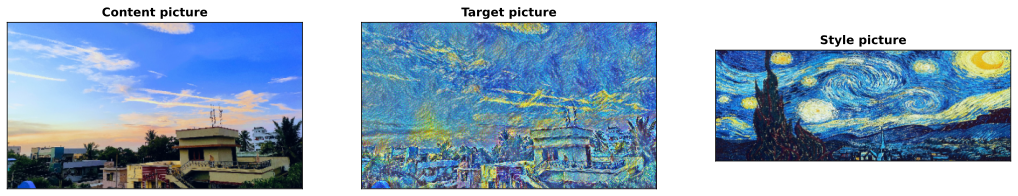

In [13]:

# the "after" pic
fig,ax = plt.subplots(1,3,figsize=(18,11))

pic = img4content.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[0].imshow(pic)
ax[0].set_title('Content picture',fontweight='bold')
ax[0].set_xticks([])
ax[0].set_yticks([])

pic = torch.sigmoid(target).cpu().detach().squeeze().numpy().transpose((1,2,0))
ax[1].imshow(pic)
ax[1].set_title('Target picture',fontweight='bold')
ax[1].set_xticks([])
ax[1].set_yticks([])

pic = img4style.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[2].imshow(pic,aspect=.6)
ax[2].set_title('Style picture',fontweight='bold')
ax[2].set_xticks([])
ax[2].set_yticks([])

plt.show()

In [14]:
picT = torch.sigmoid(target).cpu().detach().squeeze()
picT.shape

torch.Size([3, 256, 454])

In [15]:
from torchvision.utils import save_image
save_image(picT, 'starry-home.png')